In [1]:
import cv2
import numpy as np
import sklearn
import os
import matplotlib.pyplot as plt

In [2]:
image = cv2.imread('/home/yec23006/projects/research/KneeGrowthPlate/Knee_GrowthPlate/Images/CCC_K05_hK_FL1_s1_shift3_So.jpg')
image.shape

(15252, 10716, 3)

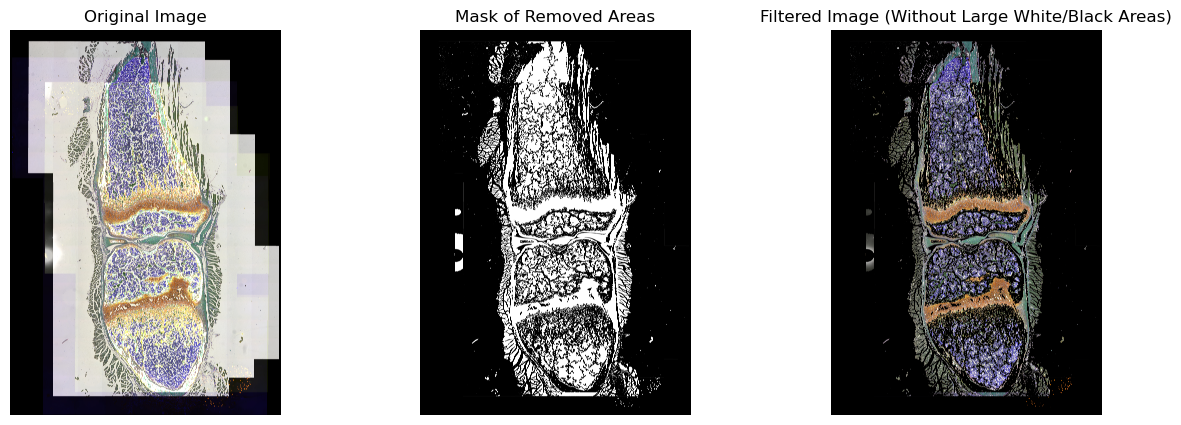

In [ ]:
# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# kernel = np.ones((5,5), np.uint8)
# dilated_gray = cv2.dilate(gray, kernel, iterations=2)

# Apply Otsu's thresholding to segment white and black regions
_, binary_white = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY)  # Detect white areas
_, binary_black = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)  # Detect black areas

# Find connected components for white and black areas
num_labels_w, labels_w, stats_w, _ = cv2.connectedComponentsWithStats(binary_white, connectivity=8)
num_labels_b, labels_b, stats_b, _ = cv2.connectedComponentsWithStats(binary_black, connectivity=8)

# Create a mask to remove large connected components
mask = np.ones_like(gray, dtype=np.uint8) * 255  # Start with a white mask

# Define size threshold (removing large background areas)
size_threshold = 5000  # Adjust this value as needed

# Remove large white areas
for i in range(1, num_labels_w):  # Skip background label 0
    if stats_w[i, cv2.CC_STAT_AREA] > size_threshold:
        mask[labels_w == i] = 0  # Set large white areas to black

# Remove large black areas
for i in range(1, num_labels_b):  # Skip background label 0
    if stats_b[i, cv2.CC_STAT_AREA] > size_threshold:
        mask[labels_b == i] = 0  # Set large black areas to black

# Apply the mask to remove connected regions
filtered_image = cv2.bitwise_and(image, image, mask=mask)

# Display results
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(mask, cmap="gray")
ax[1].set_title("Mask of Removed Areas")
ax[1].axis("off")

ax[2].imshow(cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB))
ax[2].set_title("Filtered Image (Without Large White/Black Areas)")
ax[2].axis("off")

plt.show()


In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.manifold import TSNE
import math

In [27]:
class SimpleModel(nn.Module):
    """
    Simple 2 layer models that takes in inputs (with `feat_dim` dimensions) 
    and output an embedding (with `feat_dim` dimensions)
    """
    def __init__(self, feat_dim):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(feat_dim, 256)  
        self.fc2 = nn.Linear(256, feat_dim)  

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

class ArcFaceLoss(nn.Module):
    """
    Adapted from: https://github.com/JDAI-CV/FaceX-Zoo/blob/main/head/ArcFace.py 
    """
    def __init__(self, feat_dim, num_class, margin_arc=0.9, margin_am=0.0, scale=32):
        super(ArcFaceLoss, self).__init__()
        
        # last fully connected layer that maps feature embeddings to `num_class` logits
        self.weight = nn.Parameter(torch.Tensor(feat_dim, num_class))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5)
        
        # arcface margin config
        self.margin_arc = margin_arc
        self.margin_am = margin_am
        self.scale = scale
        self.cos_margin = math.cos(margin_arc)
        self.sin_margin = math.sin(margin_arc)
        self.min_cos_theta = math.cos(math.pi - margin_arc)
        
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, feats, labels):
        kernel_norm = F.normalize(self.weight, dim=0)
        feats = F.normalize(feats)
        cos_theta = torch.mm(feats, kernel_norm) 
        cos_theta = cos_theta.clamp(-1, 1)
        sin_theta = torch.sqrt(1.0 - torch.pow(cos_theta, 2))
        cos_theta_m = cos_theta * self.cos_margin - sin_theta * self.sin_margin
        cos_theta_m = torch.where(cos_theta > self.min_cos_theta, cos_theta_m, cos_theta-self.margin_am)
        index = torch.zeros_like(cos_theta)
        index.scatter_(1, labels.data.view(-1, 1), 1)
        index = index.byte().bool()
        output = cos_theta * 1.0
        output[index] = cos_theta_m[index]
        output *= self.scale
        
        return self.loss_fn(output, labels)
        
class CrossEntropyLoss(nn.Module):
    def __init__(self, feat_dim, num_class):
        super(CrossEntropyLoss, self).__init__()
        # last fully connected layer that maps feature embeddings to `num_class` logits
        self.weight = nn.Parameter(torch.Tensor(feat_dim, num_class))
        self.weight.data.uniform_(-1, 1).renorm_(2, 1, 1e-5).mul_(1e5) 
        
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, feats, labels):
        kernel_norm = F.normalize(self.weight, dim=0)
        feats = F.normalize(feats)
        
        logits = torch.mm(feats, kernel_norm)
        return self.loss_fn(logits, labels)


# Convert colors to range [0,1]
def normalize_colors(group_colors):
    return [np.array(cluster) / 255.0 for cluster in group_colors]

def train(x_tensor, y_tensor, model, criterion, optimizer):
    """
    Simple training loop
    """
    num_epochs = 30
    
    for epoch in range(num_epochs):
        model.train()

        # forward pass
        outputs = model(x_tensor)
        loss = criterion(outputs, y_tensor)
        # backpropagation and update weights 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training loss 
        if (epoch + 1) % 3 == 0:
            print(f'Epoch {epoch+1}, Loss: {loss}')
    
    return model

In [102]:
# Define group colors
group_colors = [
    np.array([[71, 69, 130], [52, 40, 127], [189, 179, 201], [144, 139, 215], [93, 85, 133]]),  # Blue
    np.array([[173, 109, 66], [154, 94, 50], [202, 144, 97], [206, 130, 63], [161, 119, 94]]),  # Brown
    np.array([[67, 103, 62], [100, 117, 71], [112, 141, 109], [83, 97, 61], [104, 127, 121]]),  # Green
    np.array([[160, 247, 172], [191, 227, 205], [162, 213, 184], [175, 226, 161], [164, 210, 182]]), #Mint
    np.array([[238, 225, 156], [245, 207, 136], [200, 177, 127], [255, 254, 174], [251, 240, 113]])  # Yellow
]

# prep
group_colors = normalize_colors(group_colors)
X, y =[], []
label = 0
for cluster in group_colors:
    for center in cluster:
        X.append(center)
        y.append(label)
    label += 1
x_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y)

# Setting 1: Using CrossEntropyLoss
model1 = SimpleModel(feat_dim=3)
criterion1 = CrossEntropyLoss(feat_dim=3, num_class=8)
optimizer1 = optim.SGD(model1.parameters(), lr=0.001, momentum=0.8)
model1 = train(x_tensor, y_tensor, model1, criterion1, optimizer1) 
pred1 = model1(x_tensor).detach().numpy()


# Setting 2: Using ArcFace Loss
model2 = SimpleModel(feat_dim=3)
criterion2 = ArcFaceLoss(feat_dim=3, num_class=5)
optimizer2 = optim.SGD(model2.parameters(), lr=0.001, momentum=0.8)
model2 = train(x_tensor, y_tensor, model2, criterion2, optimizer2) 
pred2 = model2(x_tensor).detach().numpy()

Epoch 3, Loss: 2.0877914428710938
Epoch 6, Loss: 1.922838568687439
Epoch 9, Loss: 1.911565899848938
Epoch 12, Loss: 1.9106602668762207
Epoch 15, Loss: 1.9049415588378906
Epoch 18, Loss: 1.8983747959136963
Epoch 21, Loss: 1.892980694770813
Epoch 24, Loss: 1.8886499404907227
Epoch 27, Loss: 1.8846206665039062
Epoch 30, Loss: 1.8803491592407227
Epoch 3, Loss: 41.92060852050781
Epoch 6, Loss: 39.3460578918457
Epoch 9, Loss: 39.029083251953125
Epoch 12, Loss: 38.47637939453125
Epoch 15, Loss: 37.819515228271484
Epoch 18, Loss: 36.933990478515625
Epoch 21, Loss: 34.98031997680664
Epoch 24, Loss: 31.61151695251465
Epoch 27, Loss: 31.496217727661133
Epoch 30, Loss: 30.731117248535156


In [31]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import torch

# Convert tensors to numpy arrays
x_numpy = x_tensor.numpy()
y_numpy = y_tensor.numpy()

# Run t-SNE for each setting
tsne = TSNE(n_components=2, random_state=42)
tsne_result1 = tsne.fit_transform(pred1)
tsne_result2 = tsne.fit_transform(pred2)

# Plot the t-SNE results
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Setting 1: CrossEntropyLoss
scatter1 = axes[0].scatter(tsne_result1[:, 0], tsne_result1[:, 1], c=y_numpy, cmap='viridis', alpha=0.7)
axes[0].set_title('t-SNE Visualization (CrossEntropyLoss)')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')

# Setting 2: ArcFaceLoss
scatter2 = axes[1].scatter(tsne_result2[:, 0], tsne_result2[:, 1], c=y_numpy, cmap='viridis', alpha=0.7)
axes[1].set_title('t-SNE Visualization (ArcFaceLoss)')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')

plt.colorbar(scatter1, ax=axes[0])
plt.colorbar(scatter2, ax=axes[1])

plt.tight_layout()
plt.show()


ValueError: perplexity must be less than n_samples

# Clustering loss

Epoch 0: Loss = 0.1966
Epoch 10: Loss = 0.0018
Epoch 20: Loss = 0.0004
Epoch 30: Loss = 0.0001
Epoch 40: Loss = 0.0001


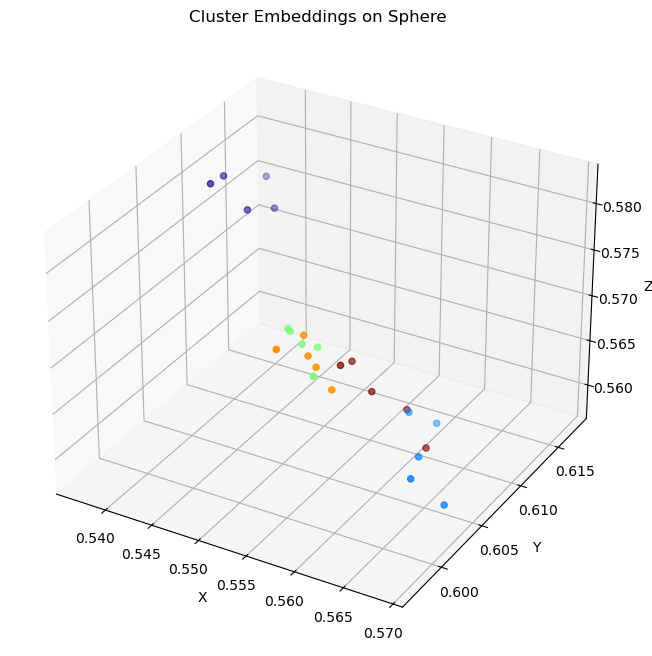

In [160]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

colors = [torch.tensor(group, dtype = torch.float32)/255.0 for group in [
    np.array([[71, 69, 130], [52, 40, 127], [189, 179, 201], [144, 139, 215], [93, 85, 133]]),  # Blue
    np.array([[173, 109, 66], [154, 94, 50], [202, 144, 97], [206, 130, 63], [161, 119, 94]]),  # Brown
    np.array([[67, 103, 62], [100, 117, 71], [112, 141, 109], [83, 97, 61], [104, 127, 121]]),  # Green
    np.array([[160, 247, 172], [191, 227, 205], [162, 213, 184], [175, 226, 161], [164, 210, 182]]), #Mint
    np.array([[238, 225, 156], [245, 207, 136], [200, 177, 127], [255, 254, 174], [251, 240, 113]])  # Yellow
]]

# Flatten and store cluster labels
X = torch.cat(colors)
y = torch.cat([torch.full((len(group),), i) for i, group in enumerate(colors)])

# Normalize to unit sphere
X = X / torch.norm(X, dim=1, keepdim=True)

# Learnable embeddings
embedding_dim = 3  # Using 3D embeddings for easier visualization

class ClusterEmbedding(nn.Module):
    def __init__(self, input_dim, embedding_dim, num_clusters):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=embedding_dim, kernel_size=3, padding=1),
            nn.BatchNorm1d(embedding_dim),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.cluster_centers = nn.Parameter(torch.randn(num_clusters, embedding_dim))

    def forward(self, x):
        x = x.unsqueeze(1)  # (N, 1, 3)
        x = self.cnn(x).squeeze(2)  # (N, 3)
        x = x / torch.norm(x, dim=1, keepdim=True)  # Normalize to unit sphere
        return x

model = ClusterEmbedding(input_dim=3, embedding_dim=embedding_dim, num_clusters=len(colors))
optimizer = optim.Adam(model.parameters(), lr=0.005)


def cosine_similarity_3d(vector_a, vector_b):
    """
    Calculate the cosine similarity between two 3D vectors.

    Args:
        vector_a (list or numpy.ndarray): The first 3D vector.
        vector_b (list or numpy.ndarray): The second 3D vector.

    Returns:
        float: The cosine similarity between the two vectors.
    """
    a = np.array(vector_a)
    b = np.array(vector_b)
    dot_product = np.dot(a, b)
    magnitude_a = np.linalg.norm(a)
    magnitude_b = np.linalg.norm(b)

    if magnitude_a == 0 or magnitude_b == 0:
        return 0  # Handle zero vector case

    return dot_product / (magnitude_a * magnitude_b)

def cosine_similarity_torch(vector_a, vector_b):
    """
    Calculate the cosine similarity between two 3D vectors in PyTorch.

    Args:
        vector_a (torch.Tensor): The first 3D vector.
        vector_b (torch.Tensor): The second 3D vector.

    Returns:
        torch.Tensor: The cosine similarity between the two vectors.
    """
    dot_product = torch.sum(vector_a * vector_b, dim=-1)
    magnitude_a = torch.norm(vector_a, dim=-1)
    magnitude_b = torch.norm(vector_b, dim=-1)

    return dot_product / (magnitude_a * magnitude_b + 1e-8)  # Avoid division by zero



# Loss function: inter-cluster angle separation using farthest points
def clustering_loss(embeddings, labels):
    intra_loss = torch.tensor(0.0, device=embeddings.device)
    inter_loss = torch.tensor(0.0, device=embeddings.device)
    cluster_centers = []

    for i in range(len(colors)):
        cluster_embeds = embeddings[labels == i]
        if cluster_embeds.shape[0] == 0:
            continue
        
        center = torch.mean(cluster_embeds, dim=0)
        cluster_centers.append(center)

        # Intra-cluster compactness: Pull points closer to center
        if cluster_embeds.shape[0] > 1:
            cosine_sim = cosine_similarity_torch(cluster_embeds, center.unsqueeze(0))
            intra_loss = intra_loss + torch.mean(1 - cosine_sim)  # Minimize angle within cluster

    if len(cluster_centers) > 1:
        cluster_centers = torch.stack(cluster_centers)

        # Inter-cluster separation: Push centers further apart
        for i in range(len(cluster_centers)):
            for j in range(i + 1, len(cluster_centers)):
                cosine_sim_inter = cosine_similarity_torch(cluster_centers[i].unsqueeze(0), cluster_centers[j].unsqueeze(0))
                inter_loss = inter_loss + cosine_sim_inter  # Increase angle between clusters

    return intra_loss #- 0.01*inter_loss  #######################


# Training loop
for epoch in range(50):
    optimizer.zero_grad()
    embeddings = model(X)
    loss = clustering_loss(embeddings, y)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

# Get final embeddings
final_embeddings = model(X).detach().numpy()

# Visualize embeddings on a 3D sphere
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(final_embeddings[:, 0], final_embeddings[:, 1], final_embeddings[:, 2], c=y.numpy(), cmap='jet')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Cluster Embeddings on Sphere')
plt.show()



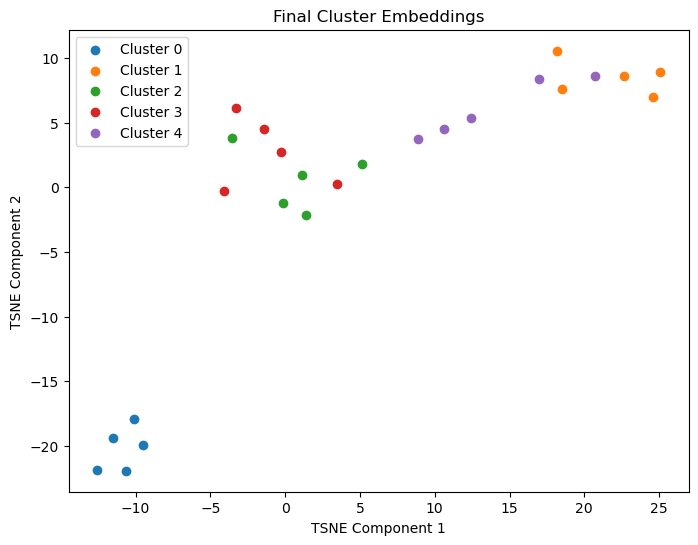

In [163]:
from sklearn.manifold import TSNE

def visualize_embeddings(embeddings, labels, title="Cluster Visualization"):
    tsne = TSNE(n_components=2, perplexity=5, learning_rate=10, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(8, 6))
    for i in range(len(colors)):
        plt.scatter(embeddings_2d[labels == i, 0], embeddings_2d[labels == i, 1], label=f'Cluster {i}')
    
    plt.legend()
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.title(title)
    plt.show()

# Plot embeddings after training
final_embeddings = model(X).detach().numpy()
visualize_embeddings(final_embeddings, y.numpy(), title="Final Cluster Embeddings")


# New ver

Epoch 0: Loss = 6.1135
Epoch 10: Loss = 0.2825
Epoch 20: Loss = -0.3330
Epoch 30: Loss = -0.4618
Epoch 40: Loss = -0.5926
Epoch 50: Loss = -0.6752
Epoch 60: Loss = -0.7530
Epoch 70: Loss = -0.8220
Epoch 80: Loss = -0.8780
Epoch 90: Loss = -0.9191


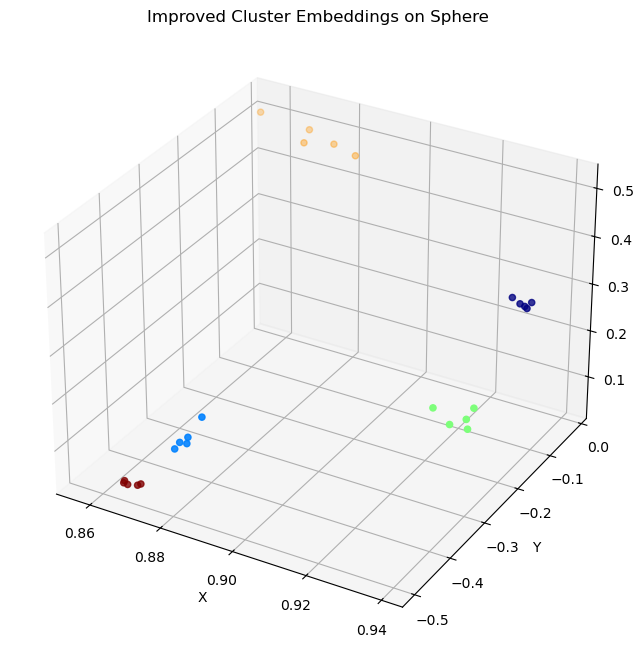

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Generate normalized cluster centers
num_clusters = 5
points_per_cluster = 5
embedding_dim = 3

# Generate cluster centers evenly distributed on a sphere
def generate_spherical_points(n_clusters, dim):
    torch.manual_seed(42)  # Fix seed for reproducibility
    points = torch.randn(n_clusters, dim)
    return points / torch.norm(points, dim=1, keepdim=True)

cluster_centers = generate_spherical_points(num_clusters, embedding_dim)

# Generate points around each cluster center
cluster_std = 0.05  # Spread of each cluster
X = []
y = []
for i, center in enumerate(cluster_centers):
    points = center + cluster_std * torch.randn(points_per_cluster, embedding_dim)
    X.append(points)
    y.append(torch.full((points_per_cluster,), i))

X = torch.cat(X)
y = torch.cat(y)

class ClusterEmbedding(nn.Module):
    def __init__(self, input_dim, embedding_dim, num_clusters):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, embedding_dim)
        )
        self.cluster_centers = nn.Parameter(generate_spherical_points(num_clusters, embedding_dim))

    def forward(self, x):
        x = self.fc(x)
        x = x / torch.norm(x, dim=1, keepdim=True)  # Normalize
        return x

model = ClusterEmbedding(input_dim=embedding_dim, embedding_dim=embedding_dim, num_clusters=num_clusters)
optimizer = optim.Adam(model.parameters(), lr=0.01)

def clustering_loss(embeddings, labels, cluster_centers):
    intra_loss = 0
    inter_loss = 0
    cluster_embeddings = [embeddings[labels == i] for i in range(num_clusters)]
    
    # Intra-cluster compactness
    for i, cluster_embeds in enumerate(cluster_embeddings):
        if cluster_embeds.shape[0] > 1:
            intra_loss += torch.mean(1 - torch.cosine_similarity(cluster_embeds, cluster_centers[i].unsqueeze(0)))
    
    # Inter-cluster separation
    for i in range(num_clusters):
        for j in range(i + 1, num_clusters):
            inter_loss += torch.cosine_similarity(cluster_centers[i].unsqueeze(0), cluster_centers[j].unsqueeze(0))
    
    return intra_loss - 0.1 * inter_loss  # Adjust balance factor

# Training loop
for epoch in range(100):
    optimizer.zero_grad()
    embeddings = model(X)
    loss = clustering_loss(embeddings, y, model.cluster_centers)
    loss.backward()
    optimizer.step()
    
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")

# Visualize embeddings
final_embeddings = model(X).detach().numpy()
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(final_embeddings[:, 0], final_embeddings[:, 1], final_embeddings[:, 2], c=y.numpy(), cmap='jet')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Improved Cluster Embeddings on Sphere')
plt.show()

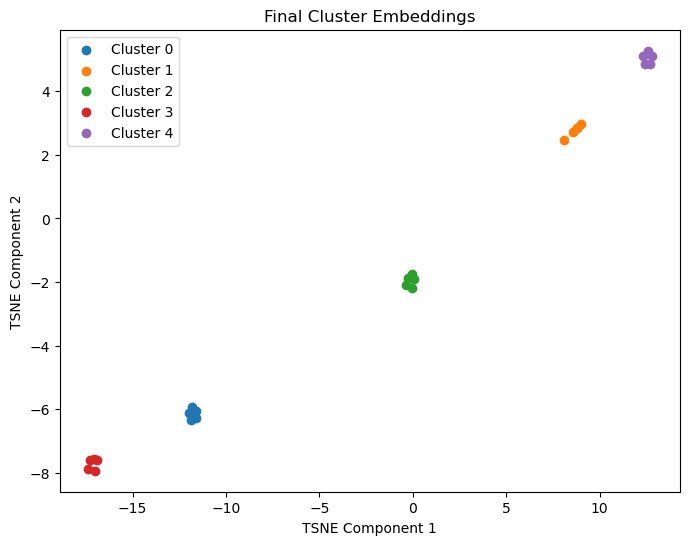

In [165]:
from sklearn.manifold import TSNE

def visualize_embeddings(embeddings, labels, title="Cluster Visualization"):
    tsne = TSNE(n_components=2, perplexity=5, learning_rate=10, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    plt.figure(figsize=(8, 6))
    for i in range(len(colors)):
        plt.scatter(embeddings_2d[labels == i, 0], embeddings_2d[labels == i, 1], label=f'Cluster {i}')
    
    plt.legend()
    plt.xlabel('TSNE Component 1')
    plt.ylabel('TSNE Component 2')
    plt.title(title)
    plt.show()

# Plot embeddings after training
visualize_embeddings(final_embeddings, y.numpy(), title="Final Cluster Embeddings")

In [168]:
y.numpy()

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4,
       4, 4, 4])

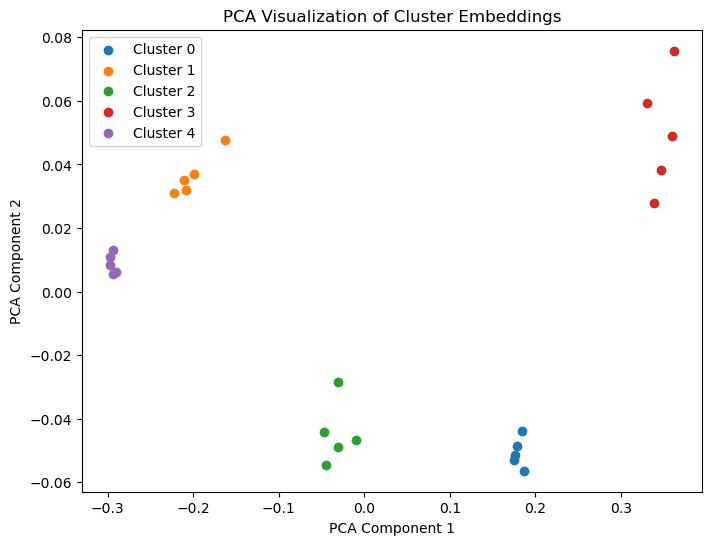

In [170]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming `final_embeddings` and `cluster_labels` are available
# If using saved files, load them as:
# final_embeddings = np.load("final_embeddings.npy")
# cluster_labels = np.load("cluster_labels.npy")

# Apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(final_embeddings)

# Plot PCA results
plt.figure(figsize=(8, 6))
for i in np.unique(y.numpy()):
    plt.scatter(
        pca_embeddings[y.numpy() == i, 0],
        pca_embeddings[y.numpy() == i, 1],
        label=f'Cluster {i}'
    )

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Visualization of Cluster Embeddings')
plt.legend()
plt.show()


# PSD to JPEG

In [3]:
from psd_tools import PSDImage
from PIL import Image
import os

In [19]:
def convert_psd_to_jpeg(psd_path, jpeg_path, quality=100):
    psd = PSDImage.open(psd_path)
    print(psd, len(psd))
    for idx, layer in enumerate(psd.descendants()):
        layer_image = layer.composite()
        if layer_image:
            save2 = os.path.join(jpeg_path, f'{layer.name}.png')
            layer_image.convert("RGB").save(save2, "PNG", quality=quality)

In [20]:
sample_list = os.listdir('image/psd')

for psdfile in sample_list:
    samplename = psdfile.split('.')[0]
    os.mkdir('image/png/' + samplename)
    path2jpeg = 'image/png/'+samplename

    convert_psd_to_jpeg('image/psd/' + psdfile, path2jpeg)


PSDImage(mode=3 size=4250x3699 depth=8 channels=4) 32
PSDImage(mode=3 size=4217x3294 depth=8 channels=4) 32
PSDImage(mode=3 size=4257x2870 depth=8 channels=4) 30
PSDImage(mode=3 size=4470x3808 depth=8 channels=4) 35
PSDImage(mode=3 size=4223x3292 depth=8 channels=4) 36
PSDImage(mode=3 size=4302x2816 depth=8 channels=4) 37
PSDImage(mode=3 size=4230x3082 depth=8 channels=4) 34
PSDImage(mode=3 size=4320x3141 depth=8 channels=4) 36
PSDImage(mode=3 size=4506x2925 depth=8 channels=4) 37
